In [322]:
## Импорт необходимых библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [323]:
## Загрузка данных

try:
    data = pd.read_excel('prflat.xlsx')
    print("Данные успешно загружены. Размер таблицы:", data.shape)
except FileNotFoundError:
    print("Ошибка: Файл не найден.")

Данные успешно загружены. Размер таблицы: (600, 10)


In [324]:
## Преобразования названий столбцов

data.columns = data.columns.str.replace(' ', '_').str.replace(',', '').str.replace('(', '').str.replace(')', '')

In [325]:
## Предварительный анализ данных

# Просмотр первых строк данных
print("\nПервые 5 строк данных:")
display(data.head())

# Основная информация о данных
print("\nИнформация о данных:")
data.info()


Первые 5 строк данных:


,Адрес,Площадь_м2,Парковка,Ремонт,Балкон,Лифт,Цена,Тип_Дома,Этаж,Этажность_дома
0,"Свердловская область, Екатеринбург, улица Степ...",35.7,отсутствует,Косметический,Лоджия (1),отсутствует,7000000,Монолитный,5,16
1,"Свердловская область, Екатеринбург, проспект К...",39.0,отсутствует,Евроремонт,Балкон (1),отсутствует,6999000,Монолитный,4,13
2,"Свердловская область, Екатеринбург, переулок З...",50.0,подземная,Косметический,Балкон (1),отсутствует,6999000,Монолитный,16,20
3,"Свердловская область, Екатеринбург, улица Начд...",38.8,отсутствует,Евроремонт,Лоджия (1),отсутствует,6999000,Монолитный,23,27
4,"Свердловская область, Екатеринбург, улица Репи...",40.0,отсутствует,Косметический,Лоджия (1),отсутствует,6990000,Панельный,15,26



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Адрес           600 non-null    object 
 1   Площадь_м2      600 non-null    float64
 2   Парковка        600 non-null    object 
 3   Ремонт          600 non-null    object 
 4   Балкон          600 non-null    object 
 5   Лифт            600 non-null    object 
 6   Цена            600 non-null    int64  
 7   Тип_Дома        600 non-null    object 
 8   Этаж            600 non-null    int64  
 9   Этажность_дома  600 non-null    int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 47.0+ KB


In [326]:
## Предобработка данных

# Удаление ненужных столбцов
columns_to_drop = ['Адрес']
data_clean = data.drop(columns=columns_to_drop, errors='ignore')

# Заполнение пропущенных значений (если есть)
data_clean = data_clean.ffill().bfill()

# Разделение на признаки (X) и целевую переменную (y)
X = data_clean.drop(columns=['Цена'])
y = data_clean['Цена']

# Определение категориальных и числовых признаков
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

print("\nКатегориальные признаки:", list(categorical_cols))
print("Числовые признаки:", list(numeric_cols))


Категориальные признаки: ['Парковка', 'Ремонт', 'Балкон', 'Лифт', 'Тип_Дома']
Числовые признаки: ['Площадь_м2', 'Этаж', 'Этажность_дома']


In [327]:
## Преобразование категориальных признаков

# Создаем копию данных для преобразования
X_processed = X.copy()

# Применяем LabelEncoder к категориальным признакам
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [328]:
## Разделение данных на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

print(f"\nРазмеры выборок:")
print(f"Обучающая: {X_train.shape}, Тестовая: {X_test.shape}")


Размеры выборок:
Обучающая: (480, 8), Тестовая: (120, 8)


In [329]:
# Создание датасетов LightGBM

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'colsample_bytree': 0.9,
    'subsample': 0.8,
    'subsample_freq': 5,
    'min_split_gain': 0.0,
    'min_child_samples': 20,
    'random_state': 42,
    'verbose': -1
}

# Создание модели
model = lgb.LGBMRegressor(**params, n_estimators=1000)

# Обучение модели
print("\nНачинаем обучение модели...")
model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', 
          callbacks=[lgb.early_stopping(stopping_rounds=50)])
print("\nОбучение завершено!")

# Предсказание на тестовом наборе
y_pred = model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")


Начинаем обучение модели...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[265]	valid_0's l1: 459915

Обучение завершено!
Mean Absolute Error: 459914.8290176787



Оценка качества модели:
Средняя абсолютная ошибка (MAE): 459914.83 руб.
Коэффициент детерминации (R²): 0.727


<Figure size 1000x800 with 0 Axes>

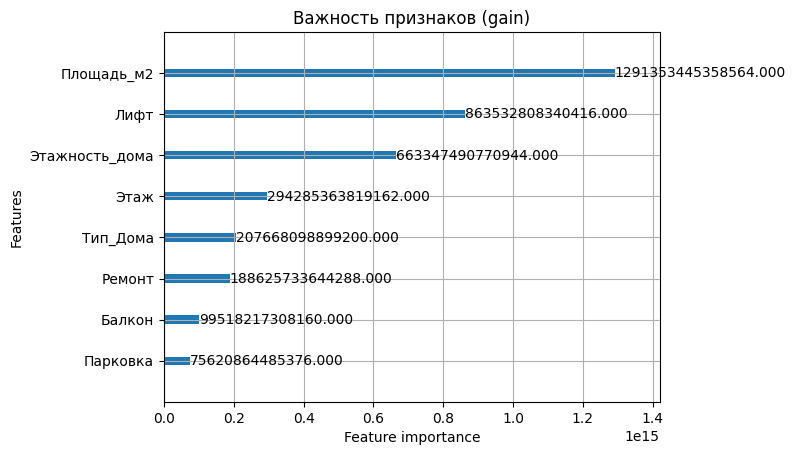

In [330]:
## Оценка качества модели

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Расчет метрик
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nОценка качества модели:")
print(f"Средняя абсолютная ошибка (MAE): {mae:.2f} руб.")
print(f"Коэффициент детерминации (R²): {r2:.3f}")

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
lgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title('Важность признаков (gain)')
plt.show()

In [331]:
# Вычисление абсолютных ошибок
errors = np.abs(y_pred - y_test)

# Создание DataFrame для анализа
results = pd.DataFrame({
    'sq': X_test['Площадь_м2'],
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': errors
})

# Сортировка по ошибкам в порядке убывания
results_sorted = results.sort_values(by='Error', ascending=False)

# Просмотр случаев с наибольшими ошибками
print(results_sorted.head(10))

       sq   Actual     Predicted         Error
90   35.0  5550000  4.070641e+06  1.479359e+06
575  30.0  3000000  4.175855e+06  1.175855e+06
596  29.9  2400000  3.518085e+06  1.118085e+06
598  13.2  2290000  3.405973e+06  1.115973e+06
591  23.7  2599999  3.619723e+06  1.019724e+06
556  34.6  3300000  4.309285e+06  1.009285e+06
494  34.0  3800000  4.802370e+06  1.002370e+06
595  33.0  2500000  3.469446e+06  9.694462e+05
584  29.4  2850000  3.801648e+06  9.516475e+05
163  32.0  4700000  3.757309e+06  9.426907e+05


In [332]:
## Функция для определения цены квартиры

def interpolate_price(value, column, df):
    """Интерполяция цены на основе существующих данных в указанной колонке."""
    
    # Проверяем наличие точного значения
    if value in df[column].values:
        return df.loc[df[column] == value, "Цена"].values[0]
    
    # Находим ближайшие значения для интерполяции
    lower_values = df[df[column] < value][column]
    upper_values = df[df[column] > value][column]
    
    lower_value = lower_values.max() if not lower_values.empty else None
    upper_value = upper_values.min() if not upper_values.empty else None
    
    # Если указано значение ниже минимального
    if lower_value is None:
        upper_price = df.loc[df[column] == upper_value, "Цена"].values[0]
        return upper_price * (value / upper_value)  # Уменьшаем цену пропорционально
    
    # Если указано значение выше максимального
    if upper_value is None:
        lower_price = df.loc[df[column] == lower_value, "Цена"].values[0]
        return lower_price * (value / lower_value)  # Увеличиваем цену пропорционально
    
    # Находим соответствующие цены для нижнего и верхнего значений
    lower_price = df.loc[df[column] == lower_value, "Цена"].values[0]
    upper_price = df.loc[df[column] == upper_value, "Цена"].values[0]
    
    # Линейная интерполяция цены
    interpolated_price = lower_price + (upper_price - lower_price) * ((value - lower_value) / (upper_value - lower_value))
    
    return interpolated_price

def predict_apartment_price(input_features):
    
    # Интерполируем площадь квартиры
    input_features["Цена"] = interpolate_price(input_features["Площадь_м2"], "Площадь_м2", data_clean)
    
    # Создаем DataFrame из входных данных
    input_df = pd.DataFrame([input_features])
    
    # Преобразуем категориальные признаки с использованием LabelEncoder'ов
    for col in categorical_cols:
        if col in input_df.columns:
            try:
                input_df[col] = label_encoders[col].transform(input_df[col].astype(str))
            except ValueError:
                print(f"Значение {input_df[col]} не найдено в обучающих данных. Используем значение по умолчанию.")
                input_df[col] = label_encoders[col].transform([label_encoders[col].classes_[0]])
    
    # Добавляем отсутствующие колонки (если есть)
    for col in X_processed.columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Упорядочиваем колонки как в обучающих данных
    input_df = input_df[X_processed.columns]
    
    # Делаем предсказание цены квартиры с учетом интерполированной цены
    predicted_price = model.predict(input_df)[0]
    
    return predicted_price

In [333]:
## Пример использования функции определения цены квартиры

example_apartment = {
   "Площадь_м2": 33,
   "Парковка": "наземная",
   "Ремонт": "Косметический",
   "Балкон": "Лоджия (1)",
   "Лифт": "Пасс (1)",
   "Тип_дома": "Панельный",
   "Этаж": 7,
   "Этажность_дома": 9 
}

# Определение цены квартиры
predicted_price = predict_apartment_price(example_apartment)
print(f"\nПредсказанная цена квартиры: {predicted_price:,.2f} руб.")


Предсказанная цена квартиры: 3,986,988.21 руб.
